## Batter Comparison Template

In [6]:
### Import Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb
import requests

In [7]:
data = requests.get("https://www.fangraphs.com/api/leaders/major-league/data?age=&pos=all&stats=bat&lg=all&season=2024&season1=2024&ind=0&qual=0&type=8&month=0&pageitems=500000").json()

# Convert the fetched data into a pandas DataFrame
df = pd.DataFrame(data=data['data'])

## Generate Player Data Frame from MLB Stats API

In [8]:
def get_players(sport_id=1):
    # Fetch player data from the MLB API
    player_data = requests.get(url=f'https://statsapi.mlb.com/api/v1/sports/{sport_id}/players').json()

    # Select relevant data that will help distinguish players from one another
    fullName_list = [x['fullName'] for x in player_data['people']]
    id_list = [x['id'] for x in player_data['people']]
    position_list = [x['primaryPosition']['abbreviation'] for x in player_data['people']]
    team_list = [x['currentTeam']['id'] for x in player_data['people']]
    age_list = [x['currentAge'] for x in player_data['people']]

    # Create a DataFrame with the selected player data
    player_df = pd.DataFrame(data={
        'player_id': id_list,
        'name': fullName_list,
        'position': position_list,
        'team': team_list,
        'age': age_list
    })
    return player_df

# Get player data and store it in a DataFrame
player_df = get_players()

## Set up Data Frame for Plotting

In [9]:
# Generate URLs for player headshots and store them in the 'picture' column
df['picture'] = [f'https://img.mlbstatic.com/mlb-photos/image/upload/w_180,d_people:generic:headshot:silo:current.png,q_auto:best,f_auto/v1/people/{i}/headshot/silo/current' for i in df['xMLBAMID']]

# Calculate Extra Base Hits (XBH) by summing doubles (2B), triples (3B), and home runs (HR)
df['XBH'] = df['2B'] + df['3B'] + df['HR']

# Dictionary to format statistics for display
stats_dict = {
    'AB': {'format': '{:.0f}'},   # At Bats
    'AVG': {'format': '{:.3f}'},  # Batting Average
    'OBP': {'format': '{:.3f}'},  # On-base Percentage
    'SLG': {'format': '{:.3f}'},  # Slugging
    'OPS': {'format': '{:.3f}'},  # On-base Plus Slugging
    'R': {'format': '{:.0f}'},    # Runs
    'H': {'format': '{:.0f}'},    # Hits
    'XBH': {'format': '{:.0f}'},  # Extra Base Hits
    '1B': {'format': '{:.0f}'},   # Singles
    '2B': {'format': '{:.0f}'},   # Doubles
    'HR': {'format': '{:.0f}'},   # Home Runs
    'RBI': {'format': '{:.0f}'},  # Runs Batted In
}

# List of players to be analyzed
player_list = ['CJ Abrams', 'Bobby Witt Jr.']


# Create a subset of the dataframe with only the desired players and statistics
subset_df = df[df['PlayerName'].isin(player_list)][['PlayerName','position']+list(stats_dict.keys())]

# Create a subset of the dataframe with headshots of the desired players
picture_df = df[df['PlayerName'].isin(player_list)]['picture']

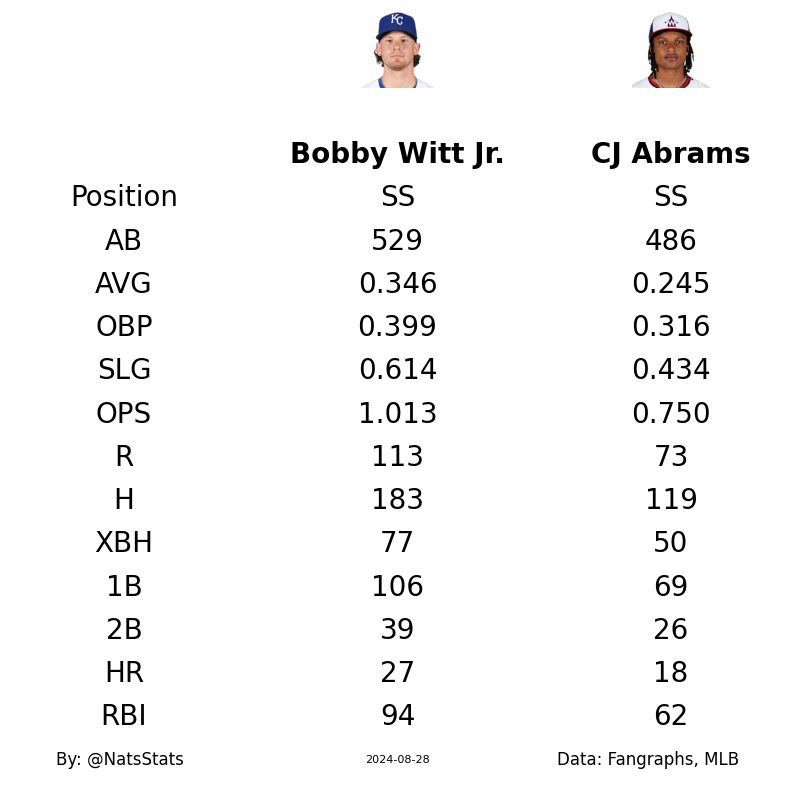

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import requests
from io import BytesIO

# Assuming subset_df and stats_dict are already defined
subset_df_transposed = subset_df.T

fig = plt.figure(figsize=(3+3.5*len(player_list), 10))
# Create a GridSpec with 3 columns and rows for stats + 2 rows for name and position
gs = gridspec.GridSpec(len(subset_df_transposed) + 3, len(player_list) + 1, figure=fig,
                       height_ratios=[2] + [1] * (len(subset_df_transposed) + 2))

# Add text annotations for each cell in the transposed DataFrame
for i, row in enumerate(subset_df_transposed.itertuples(index=False)):
    for j, value in enumerate(row):
        stat_name = subset_df_transposed.index[i]
        if stat_name in stats_dict:
            formatted_value = stats_dict[stat_name]['format'].format(value)
        else:
            formatted_value = str(value)

        ax = fig.add_subplot(gs[i + 2, j + 1])
        ax.set_xlim(0, 1)
        ax.axis('off')
        if i == 0:
            ax.text(0.5, 0.5, formatted_value, ha='center', va='center', fontsize=20, weight='bold')
        else:
            ax.text(0.5, 0.5, formatted_value, ha='center', va='center', fontsize=20)

# Add row labels
for i, label in enumerate(['', 'Position'] + list(stats_dict.keys())):
    ax = fig.add_subplot(gs[i + 2, 0])
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.text(0.5, 0.5, label, ha='center', va='center', fontsize=20)

# Add column labels
for j, label in enumerate(subset_df_transposed.columns):
    ax = fig.add_subplot(gs[0, j + 1])
    response = requests.get(picture_df[label])
    img = Image.open(BytesIO(response.content))
    ax.set_xlim(-1, 1)
    # ax.set_ylim(0, 0.2)
    ax.imshow(img, extent=[-0.5, 0.5, 0, 1], aspect=1)
    ax.axis('off')

# Add author and source at the bottom
ax_author = fig.add_subplot(gs[-1, 0])
ax_author.axis('off')
ax_author.text(0.2, 0.5, 'By: @NatsStats', ha='left', va='center', fontsize=12)

ax_source = fig.add_subplot(gs[-1, -1])
ax_source.axis('off')
ax_source.text(0.8, 0.5, 'Data: Fangraphs, MLB', ha='right', va='center', fontsize=12)

# Add current date at the bottom center
import datetime
ax_date = fig.add_subplot(gs[-1, 1:-1])
ax_date.axis('off')
ax_date.text(0.5, 0.5, datetime.datetime.today().strftime('%Y-%m-%d'),
             ha='center', va='center', fontsize=8)

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.1)

# Display the plot
plt.show()